In [1]:
from sklearn.preprocessing import MinMaxScaler

from forcast_utils import preprocessing, base_fn
import jax
from flax import nnx
import jax.numpy as jnp
import pandas as pd
import tqdm
from functools import partial

In [2]:
# First we need to define some Hyperparameters so that we can change them easily
VOLATILITY_WINDOW = 5  # Window size for calculating volatility in days
TIMESERIES_LENGTH = 20  # Length of the time series to use for training
BATCH_SIZE = 10  # Batch size for training
EPOCHS = 12  # Number of epochs to train the model

SHOW_DEBUG_INFO = True  # Whether to show debug information during training



Lets first download the data.

In [3]:
btc = preprocessing.download_data('BTC-USD', start='2015-01-01', end='2023-10-01')
#btc = yf.download('BTC-USD', start='2015-01-01', end='2023-10-01')
if SHOW_DEBUG_INFO:
    print(f"Downloaded {len(btc)} rows of data for BTC-USD")
    print(f"Columns: {btc.columns.tolist()}")
    print(f"Data types:\n{btc.dtypes}")
    btc.info()

Data for BTC-USD already downloaded.
Downloaded 3195 rows of data for BTC-USD
Columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Data types:
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 3195 entries, 2015-01-01 to 2023-09-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3195 non-null   float64
 1   High    3195 non-null   float64
 2   Low     3195 non-null   float64
 3   Open    3195 non-null   float64
 4   Volume  3195 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 149.8+ KB


In [4]:
current_path = base_fn.get_current_path() # workaround for the jupyter notebook
btc = pd.read_csv(current_path +"/data/BTC_USD-15min.csv", parse_dates=['Open time'], index_col='Open time')
data = preprocessing.preprocess_15_min_data(btc.copy(), target_column="Target", feature_columns=['Open', 'High', 'Low', 'Close', 'Volume'], window=VOLATILITY_WINDOW)
data_preprocessed = preprocessing.drop_columns(data.copy(), ['Open', 'High', 'Low', 'Close', 'Volume', 'Log_Returns_5_Volatility', 'Log_Returns', 'Log_Returns_5_Volatility_Variance', 'Close_Returns','Close_Returns_5_Volatility'])

if SHOW_DEBUG_INFO:
    print(data_preprocessed.info())
    print(data_preprocessed.head())
    # max entry for each column
    print(data_preprocessed.min())
    print(data_preprocessed.max())



                Open      High       Low     Close        Volume  \
Open time                                                          
2018-01-01  13715.65  13818.55  12750.00  13380.00   8609.915844   
2018-01-02  13382.16  15473.49  12890.02  14675.11  20078.092111   
2018-01-03  14690.00  15307.56  14150.00  14919.51  15905.667639   
2018-01-04  14919.51  15280.00  13918.04  15059.54  21329.649574   
2018-01-05  15059.56  17176.24  14600.00  16960.39  23251.491125   

            Standard_Realized_Volatility  
Open time                                 
2018-01-01                      0.067739  
2018-01-02                      0.086601  
2018-01-03                      0.061617  
2018-01-04                      0.064098  
2018-01-05                      0.072525  
Using base column: Standard_Realized_Volatility to create target column: Target
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2709 entries, 0 to 2708
Data columns (total 2 columns):
 #   Column                        N

NNow we have the data preprocessed, we can define our model and training loop.

In [5]:
if SHOW_DEBUG_INFO:
    from forcast_utils import models as custom_forcast_models
    print("Creating LSTM model...")
    garch = custom_forcast_models.GARCHModel()
    lstm = custom_forcast_models.LSTM(1, [256, 128],False, nnx.Rngs(jax.random.PRNGKey(0)))
    nnx.display(garch)
    nnx.display(lstm)

Creating LSTM model...


In [6]:
import optax
from forcast_utils.models import LSTM

def t_loss_fn(model: LSTM, x: jnp.ndarray, y: jnp.ndarray, v: int) -> jnp.ndarray:
    """ This function implements the T-loss function. Which is a loss function modeled after the Student's t-distribution.
    v is the degrees of freedom parameter. The lower the v, the heavier the tails of the distribution."""
    assert v > 2, "Degrees of freedom v must be greater than 2 for the T-loss function to be well-defined."
    y_pred = model(x)
    regularization_term = jnp.log(jnp.square(y_pred))/2  # Regularization term to prevent overfitting
    error_term = (v+1)/2 * jnp.log(1+(jnp.square(y)/((v -2) * jnp.square(y_pred))))
    loss = jnp.mean(error_term + regularization_term)  # Mean of the negative log-likelihood
    return loss

def corrected_t_loss_fn(model: LSTM, x: jnp.ndarray, y: jnp.ndarray, v: int) -> jnp.ndarray:
    """
    This function implements a corrected T-loss function based on the
    Student's t-distribution.

    Args:
      model: The neural network model.
      x: The input data.
      y: The true target values.
      v: The degrees of freedom for the t-distribution. Must be > 0.
    """
    assert v > 0, "Degrees of freedom v must be greater than 0."

    # Get the model's prediction
    y_pred = model(x)

    residual = y - y_pred
    # The essential part of the negative log-likelihood of the Student's t-distribution
    loss = (v + 1) / 2 * jnp.log(1 + jnp.square(residual) / v)
    return jnp.mean(loss)


def mean_absolute_error(model: LSTM, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    """Calculate the Mean Absolute Error (MAE) between predictions and true values."""
    y_pred = model(x)
    return jnp.mean(jnp.abs(y_pred - y))

# Alright, now lets define some helper functions
def compute_metrics(predictions: jnp.ndarray, targets: jnp.ndarray) -> dict:
    """Compute metrics for the model predictions."""
    mse = jnp.mean((predictions - targets) ** 2)
    mae = jnp.mean(jnp.abs(predictions - targets))
    return {'mse': mse, 'mae': mae}

def create_training_state(rng: nnx.Rngs) -> tuple[nnx.Module, optax.GradientTransformation]:
    """Create a training state for the model."""
    lstm = LSTM(features=6, rngs=rng)
    tx = optax.adam(1e-3)
    return lstm, tx

def loss_fn(model: LSTM, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    y_pred = model(x)
    return jnp.mean((y_pred - y) ** 2)

@nnx.jit
def train_step(model, optimizer, x, y):
  loss_fn = partial(t_loss_fn, v=3)  # Using a fixed v for the T-loss function
  grad_fn = nnx.value_and_grad(loss_fn)
  loss, grads = grad_fn(model, x, y)
  optimizer.update(grads)  # In place updates.
  return loss

def transform_data_to_training_timeseries(data: pd.DataFrame, window_size: int = 100) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Transform the DataFrame into a time series format for training."""
    # Convert DataFrame to JAX array
    y = jnp.array(data['Target'])
    x_unformatted = jnp.array(data.drop(columns=['Target']))
    x = jnp.array([x_unformatted[i:i + window_size] for i in range(len(x_unformatted) - window_size)])
    y = y[window_size:] # drop label for series that are not complete
    return x, y

def train_test_split(data: pd.DataFrame, test_size: float = 0.2) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Split the data into training and testing sets."""
    split_index = int(len(data) * (1 - test_size))
    train_data = data[:split_index]
    test_data = data[split_index:]
    return train_data, test_data

def scale_data(train_data: pd.DataFrame, test_data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, MinMaxScaler]:
    """Scale the data using MinMaxScaler."""
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    fitted_scaler = scaler.fit(train_data)
    train_scaled = fitted_scaler.transform(train_data)
    test_scaled = fitted_scaler.transform(test_data)
    return train_scaled, test_scaled, fitted_scaler


In [11]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data_preprocessed, test_size=0.2)
print(train_data.shape, test_data.shape)
#X_train, test_data, scaler = scale_data(train_data, test_data)


X_train, y_train = transform_data_to_training_timeseries(train_data, window_size=TIMESERIES_LENGTH)
X_train.shape

(2167, 2) (542, 2)


(2147, 20, 1)

In [7]:
# Now we can run the training loop
from sklearn.utils import shuffle
from forcast_utils import models as custom_forcast_models

def train_model(model, optimizer, X_train: jnp.ndarray, Y_train: jnp.ndarray, epochs: int = 10, batch_size: int = 32):
    """Train the LSTM model."""
    for epoch in tqdm.tqdm(range(epochs)):
        aggregate_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            x_batch: jnp.array = X_train[i:i + batch_size]
            y_batch: jnp.array = Y_train[i:i + batch_size]
            loss = train_step(model, optimizer, x_batch, y_batch)
            aggregate_loss += loss
        average_loss = aggregate_loss / batch_size
        print(f"Epoch {epoch + 1}, AVG Loss: {average_loss:.8f}")

# Define feature columns to be used




# shuffle the timeseries data
shuffled_X_train, shuffled_y_train = shuffle(X_train, y_train, random_state=42)
lstm = custom_forcast_models.LSTM(features=1, hidden_features=[128, 64], special_last_layer=False,rngs=nnx.Rngs(jax.random.PRNGKey(0)))
optimizer = nnx.Optimizer(lstm, optax.adam(1e-3))

train_model(lstm, optimizer, X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

(2167, 2) (542, 2)


  8%|▊         | 1/12 [00:02<00:25,  2.36s/it]

Epoch 1, AVG Loss: -50.67864990


 17%|█▋        | 2/12 [00:03<00:16,  1.67s/it]

Epoch 2, AVG Loss: -50.78248596


 25%|██▌       | 3/12 [00:04<00:13,  1.46s/it]

Epoch 3, AVG Loss: -50.82366562


 33%|███▎      | 4/12 [00:05<00:10,  1.36s/it]

Epoch 4, AVG Loss: -50.92692566


 42%|████▏     | 5/12 [00:07<00:09,  1.31s/it]

Epoch 5, AVG Loss: -50.95246124


 50%|█████     | 6/12 [00:08<00:08,  1.34s/it]

Epoch 6, AVG Loss: -50.97409821


 58%|█████▊    | 7/12 [00:09<00:06,  1.30s/it]

Epoch 7, AVG Loss: -50.98972321


 67%|██████▋   | 8/12 [00:11<00:05,  1.27s/it]

Epoch 8, AVG Loss: -51.00698853


 75%|███████▌  | 9/12 [00:12<00:03,  1.31s/it]

Epoch 9, AVG Loss: -51.01259613


 83%|████████▎ | 10/12 [00:13<00:02,  1.33s/it]

Epoch 10, AVG Loss: -51.03138733


 92%|█████████▏| 11/12 [00:15<00:01,  1.33s/it]

Epoch 11, AVG Loss: -51.03213501


100%|██████████| 12/12 [00:16<00:00,  1.37s/it]

Epoch 12, AVG Loss: -51.04062653


Test data shape: (522, 20, 1), Target shape: (522,)
{'mse': Array(0.00050298, dtype=float32), 'mae': Array(0.01949452, dtype=float32)}


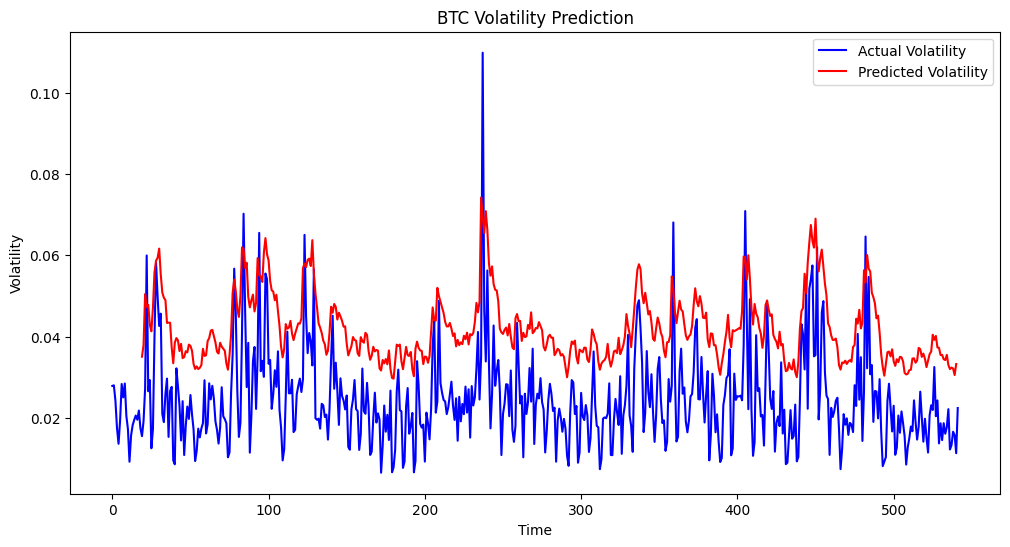

In [8]:
# Now we can evaluate the model on the test set
def evaluate_model(model: LSTM, data: pd.DataFrame):
    """Evaluate the model on the test set."""
    # First, transform the test data into the same format as the training data
    x, y = transform_data_to_training_timeseries(data, window_size=TIMESERIES_LENGTH)

    print(f"Test data shape: {x.shape}, Target shape: {y.shape}")
    prediction = model(x)
    # Rescale the predictions back to the original scale
   # prediction = scaler.inverse_transform(prediction)
   # y = scaler.inverse_transform(y)
    metrics = compute_metrics(prediction, y)

    # add TIMESERIES_LENGTH - 1 to the start of the prediction to align it with the target
    prediction = jnp.concatenate([jnp.full((TIMESERIES_LENGTH -1, 1), jnp.nan), prediction], axis=0)
    return metrics, prediction

# plot the predictions against the actual values
import matplotlib.pyplot as plt
def plot_predictions(predictions: jnp.ndarray, targets: jnp.ndarray):
    """Plot the predictions against the actual values."""
    plt.figure(figsize=(12, 6))
    plt.plot(targets, label='Actual Volatility', color='blue')
    plt.plot(predictions, label='Predicted Volatility', color='red')
    plt.title('BTC Volatility Prediction')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()


# Evaluate the model on the test set
metrics, predictions = evaluate_model(lstm, test_data)
# get the last element of every series in predictions
  # Get the last element of each series
print(metrics)
plot_predictions(predictions, test_data['Target'].to_numpy())